In [1]:
import sys
sys.path.append('/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/raygun/CycleGAN/')
from CycleGun_CBxFN90nmtile3_CBx30nmBottom100um_20210925_train import *
import matplotlib.pyplot as plt
import zarr


Importing dependencies...
Making model...
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
Training...
Training done.


In [2]:
cycleGun.test_train()

INFO:gunpowder.torch.nodes.train:Starting training from scratch
INFO:gunpowder.torch.nodes.train:Using device cuda


PipelineRequestError: Exception in pipeline:
(ZarrSource[/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/jlr54_tests/volumes/CBm_FN_lobX_90nm_tile3_twopass_rec_.n5] -> RandomLocation -> UpSample -> Normalize -> Unsqueeze -> Unsqueeze, ZarrSource[/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/jlr54_tests/volumes/CBxs_lobX_bottomp100um_30nm_rec_db9_.n5] -> RandomLocation -> Normalize -> Unsqueeze -> Unsqueeze) -> MergeProvider -> Train -> Squeeze -> Squeeze
while trying to process request

	REAL_A: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	FAKE_A: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	CYCLED_A: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	REAL_B: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	FAKE_B: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	CYCLED_B: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: None, non-spatial: False, dtype: None, placeholder: False


In [2]:
cycleGun.build_training_pipeline()
req = gp.BatchRequest()
req.add(cycleGun.real_A, cycleGun.voxel_size*cycleGun.context_side_length*cycleGun.AB_voxel_ratio)
# req.add(cycleGun.real_A_cropped, cycleGun.voxel_size*cycleGun.side_length*cycleGun.AB_voxel_ratio)
with gp.build(cycleGun.pipe_A):
    batch = cycleGun.pipe_A.request_batch(req)
batch.arrays
real_A = torch.as_tensor(batch[cycleGun.real_A].data).cuda(1)

In [3]:
cycleGun.netG1.cuda(1)

Sequential(
  (0): UNet(
    (l_conv): ModuleList(
      (0): ConvPass(
        (conv_pass): Sequential(
          (0): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): ReLU()
          (2): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): ReLU()
        )
      )
      (1): ConvPass(
        (conv_pass): Sequential(
          (0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): ReLU()
          (2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): ReLU()
        )
      )
      (2): ConvPass(
        (conv_pass): Sequential(
          (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): ReLU()
          (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): ReLU()
        )
      )
    )
    (l_down): ModuleList(
      (0): Downsample(
        (down):

In [5]:
fake_B = cycleGun.netG1(real_A)
fake_B.shape

torch.Size([1, 1, 96, 96, 96])

In [6]:
real_A.shape

torch.Size([1, 1, 96, 96, 96])

In [47]:
cycleGun.side_length * cycleGun.AB_voxel_ratio
# 2880 /30
188 / 30

6.266666666666667

In [45]:
cycleGun.context_side_length - cycleGun.side_length

44

In [33]:
fake_B.shape

torch.Size([1, 1, 188, 188, 188])

In [6]:
z = zarr.open('/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/raygun/CycleGAN/snapshots/00000075.zarr')
im = np.array(z['B']['raw']).squeeze()
z.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,2
No. arrays,0
No. groups,2
Groups,"A, B"


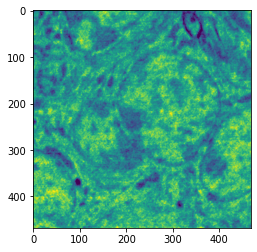

In [7]:
plt.imshow(im[234,...])

In [13]:
z = zarr.open('/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/jlr54_tests/volumes/CBm_FN_lobX_90nm_tile3_twopass_rec_.n5')
im = np.array(z['volumes']['quarterAngle'][1400:1800, 1400:1800, 1400:1800]).squeeze()
z['volumes']['quarterAngle'].info

Name,/volumes/quarterAngle
Type,zarr.core.Array
Data type,uint8
Shape,"(3216, 3216, 3216)"
Chunk shape,"(201, 201, 201)"
Order,C
Read-only,False
Compressor,"N5ChunkWrapper(chunk_shape=(201, 201, 201), compressor_config={'id': 'gzip', 'level': 5}, dtype=dtype('uint8'))"
Store type,zarr.n5.N5Store
No. bytes,33261981696 (31.0G)
No. bytes stored,373


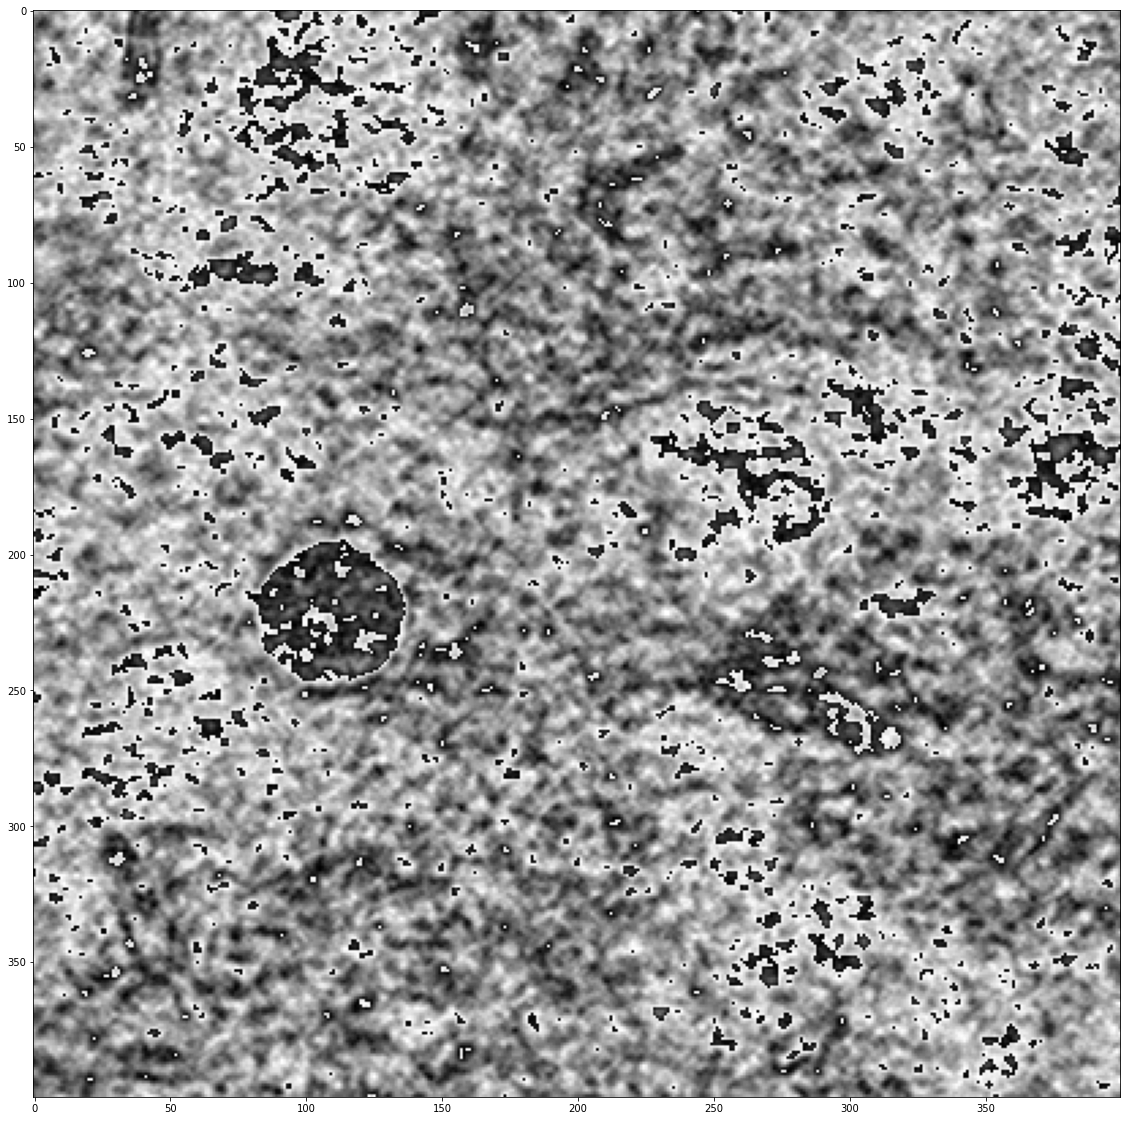

In [20]:
plt.figure(figsize=(20,20))
plt.imshow(im[200,...], cmap='gray')

In [23]:
z = zarr.open('/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/jlr54_tests/volumes/CBxs_lobX_bottomp100um_30nm_rec_db9_.n5')
im = np.array(z['volumes']['raw'][1400:1800, 1400:1800, 1024]).squeeze()
z['volumes']['raw'].info

Name,/volumes/raw
Type,zarr.core.Array
Data type,uint8
Shape,"(3216, 3216, 2048)"
Chunk shape,"(201, 201, 128)"
Order,C
Read-only,False
Compressor,"N5ChunkWrapper(chunk_shape=(201, 201, 128), compressor_config={'id': 'gzip', 'level': 5}, dtype=dtype('uint8'))"
Store type,zarr.n5.N5Store
No. bytes,21181759488 (19.7G)
No. bytes stored,373


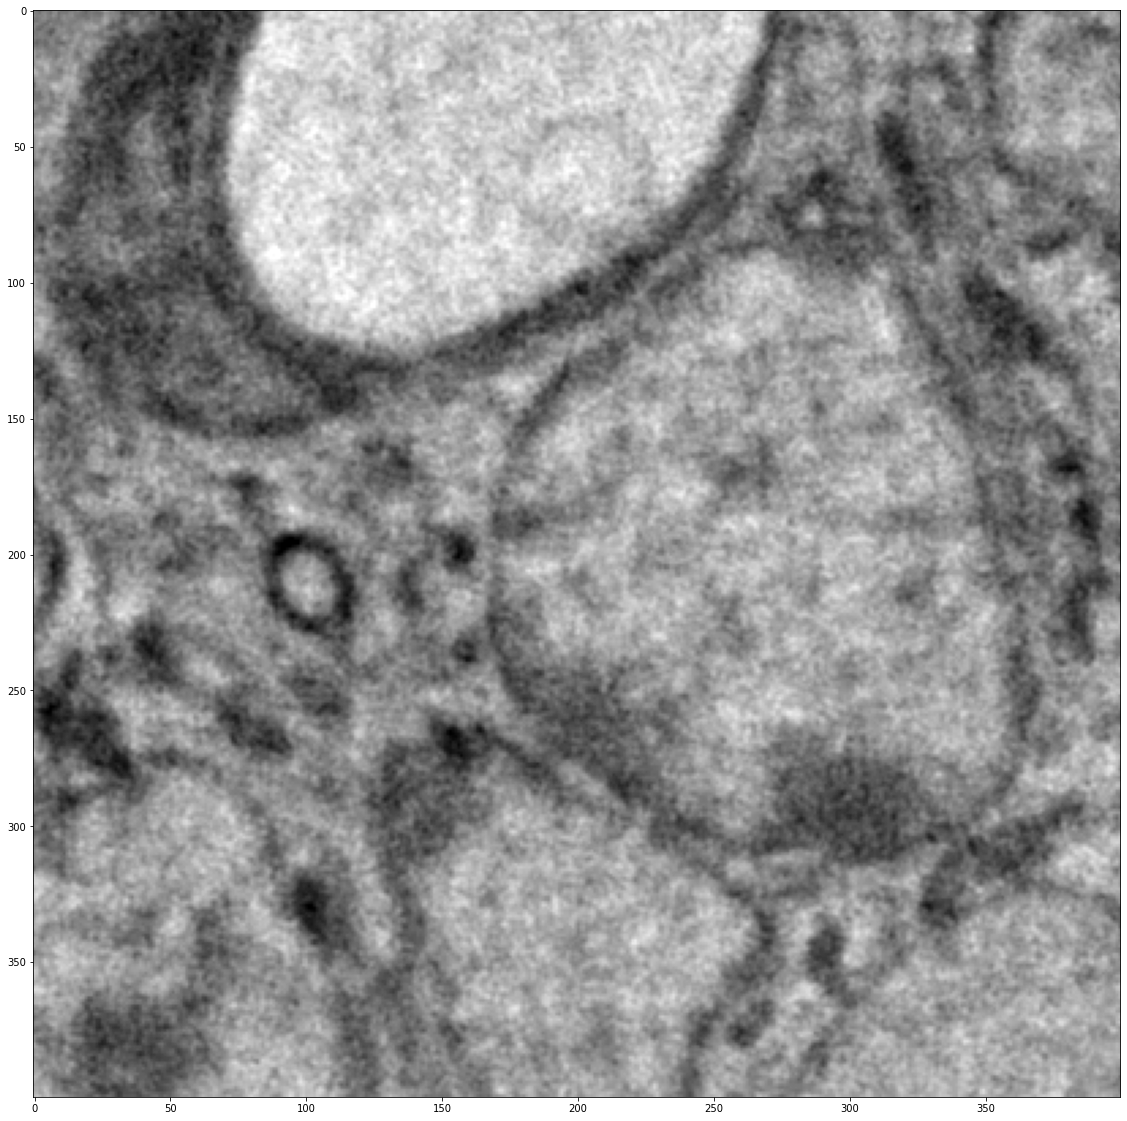

In [24]:
plt.figure(figsize=(20,20))
plt.imshow(im, cmap='gray')